epoch: 0.21, loss_g: 0.9103, loss_d: 1.1604


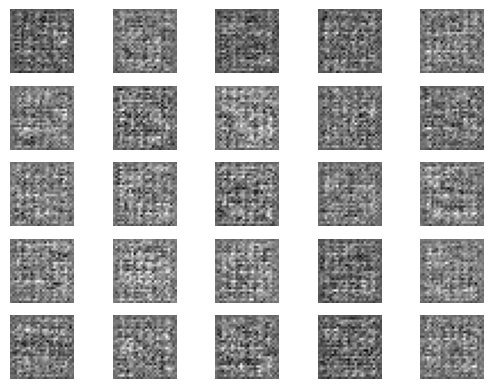

epoch: 0.43, loss_g: 1.0821, loss_d: 0.9951


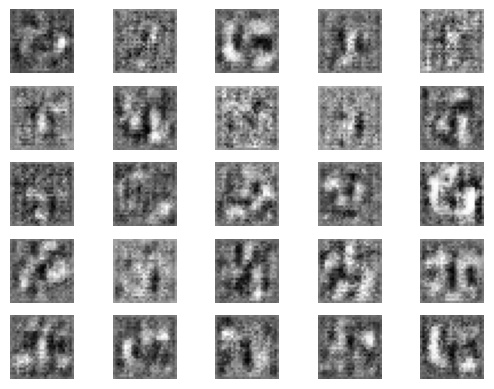

epoch: 0.64, loss_g: 1.2005, loss_d: 0.8931


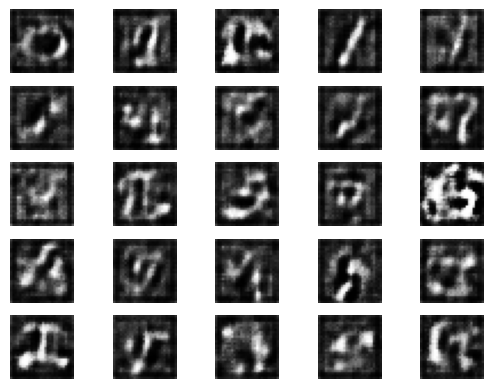

epoch: 0.85, loss_g: 1.2844, loss_d: 0.8497


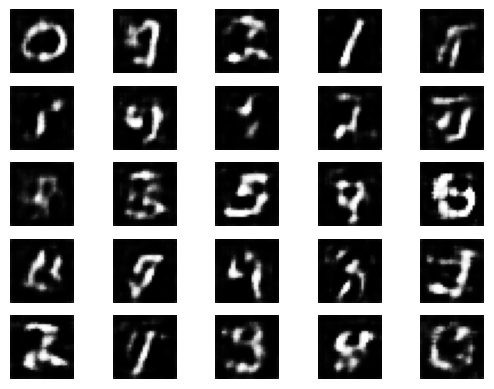

epoch: 1.21, loss_g: 1.1862, loss_d: 1.0097


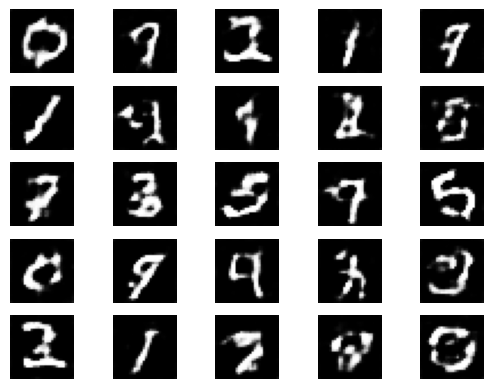

epoch: 1.43, loss_g: 1.1451, loss_d: 1.0329


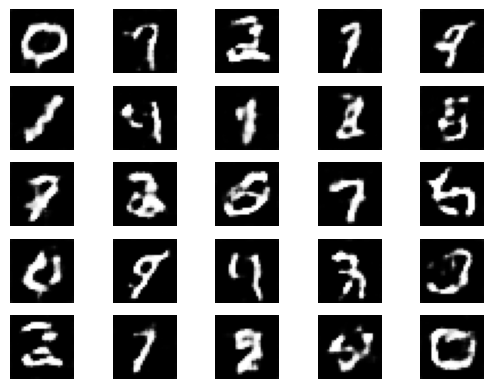

epoch: 1.64, loss_g: 1.1261, loss_d: 1.0454


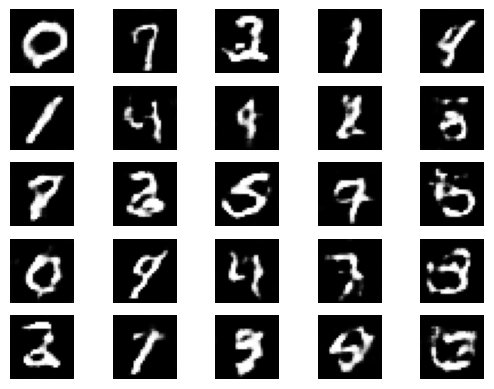

epoch: 1.85, loss_g: 1.1142, loss_d: 1.0565


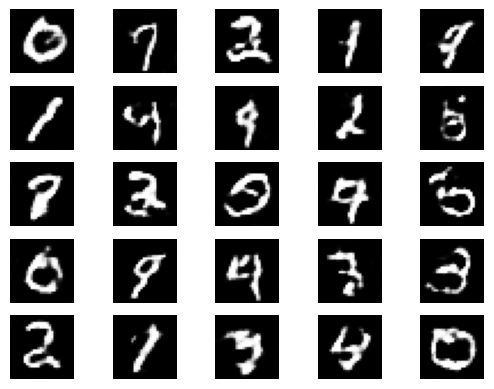

epoch: 2.21, loss_g: 1.0824, loss_d: 1.0794


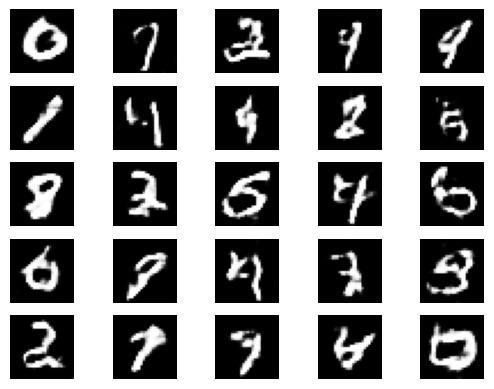

epoch: 2.43, loss_g: 1.0816, loss_d: 1.0795


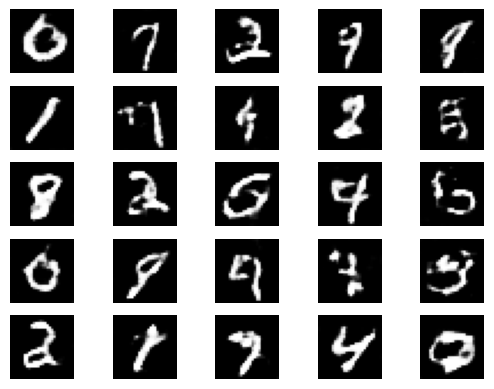

epoch: 2.64, loss_g: 1.0808, loss_d: 1.0864


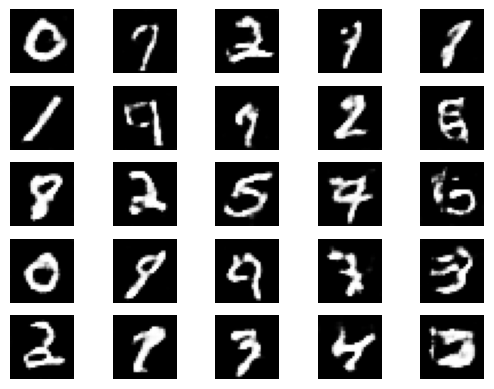

epoch: 2.85, loss_g: 1.0808, loss_d: 1.0885


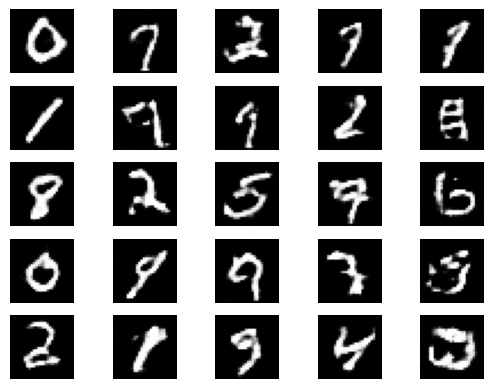

epoch: 3.21, loss_g: 1.0986, loss_d: 1.0722


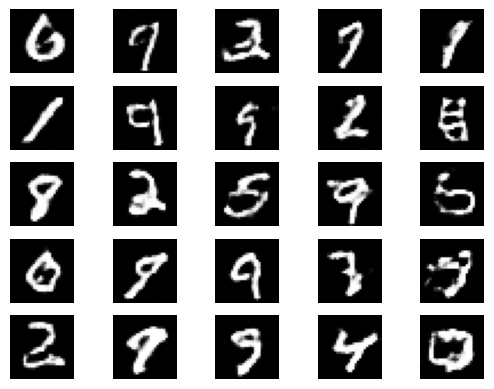

epoch: 3.43, loss_g: 1.0999, loss_d: 1.0788


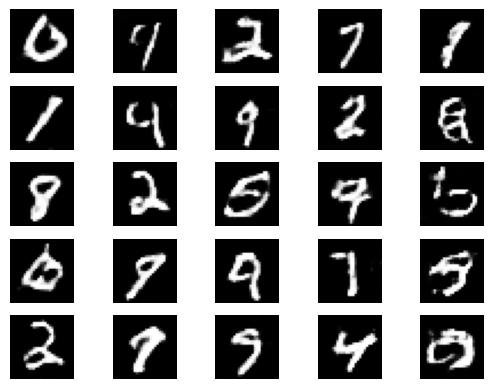

epoch: 3.64, loss_g: 1.1025, loss_d: 1.0775


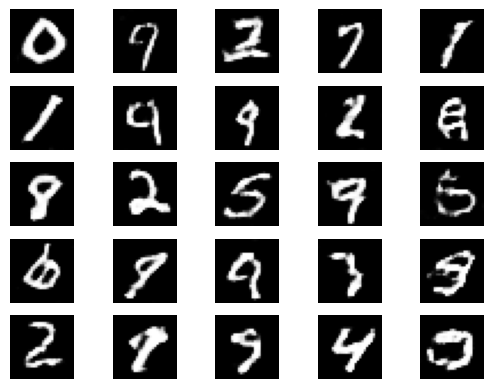

epoch: 3.85, loss_g: 1.1024, loss_d: 1.0793


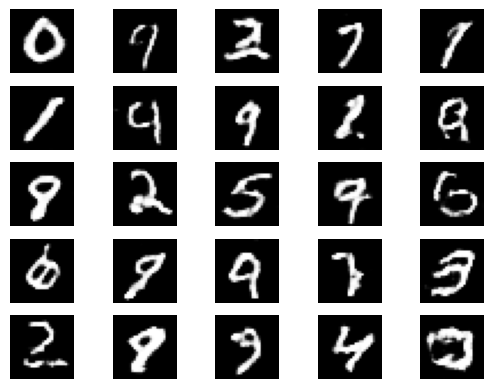

epoch: 4.21, loss_g: 1.1326, loss_d: 1.0471


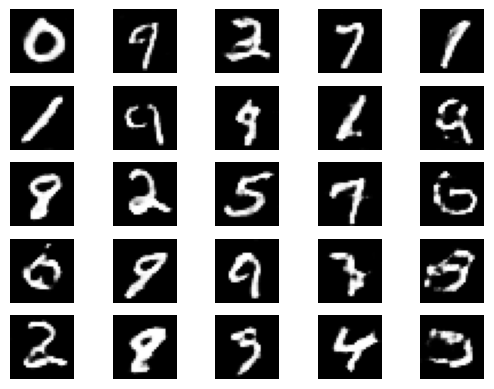

epoch: 4.43, loss_g: 1.1337, loss_d: 1.0531


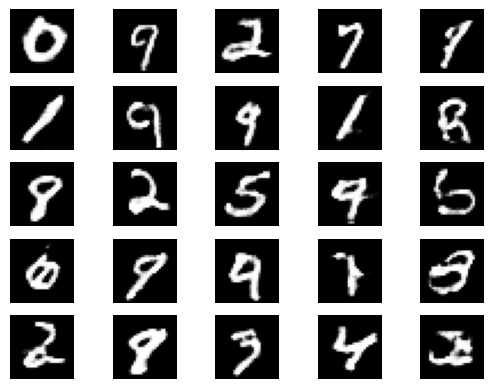

epoch: 4.64, loss_g: 1.1352, loss_d: 1.0558


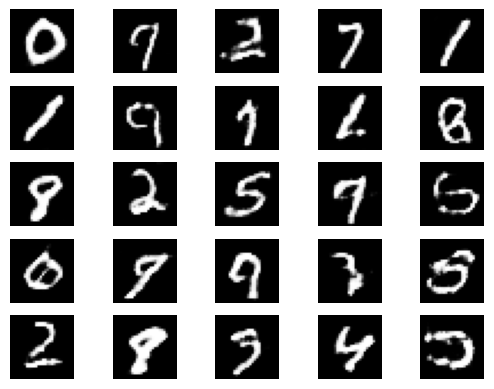

epoch: 4.85, loss_g: 1.1366, loss_d: 1.0545


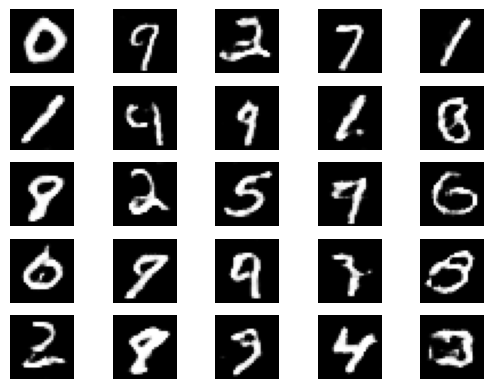

In [1]:
import sys, os
sys.path.append(os.pardir)
sys.path.append(os.curdir)
import numpy as np
import matplotlib.pyplot as plt
import axon
import axon.functions as F
import axon.layers as L
from axon import DataLoader
from axon.models import Sequential
from axon.optimizers import Adam

use_gpu = axon.core.gpu_enable
max_epoch = 5
batch_size = 128
hidden_size = 62 # 噪声维度

fc_channel, fc_height, fc_width = 128, 7, 7

# 生成器
gen = Sequential(
    L.Linear(1024),
    L.BatchNorm(),
    F.relu,
    L.Linear(fc_channel * fc_height * fc_width),
    L.BatchNorm(),
    F.relu,
    lambda x: F.reshape(x, (-1, fc_channel, fc_height, fc_width)), # 7x7
    L.Deconv2d(fc_channel // 2, kernel_size=4, stride=2, pad=1), # 14x14
    L.BatchNorm(),
    F.relu,
    L.Deconv2d(1, kernel_size=4, stride=2, pad=1), # 28x28
    F.sigmoid
)

# 判别器
dis = Sequential(
    L.Conv2d(64, kernel_size=4, stride=2, pad=1), # 14x14
    F.leaky_relu,
    L.Conv2d(128, kernel_size=4, stride=2, pad=1), # 7x7
    L.BatchNorm(),
    F.leaky_relu,
    F.flatten,
    L.Linear(1024), # 1x1
    L.BatchNorm(),
    F.leaky_relu,
    L.Linear(1),
    F.sigmoid
)

xp = axon.core.cupy
def init_weight(dis, gen, hidden_size):
    # Input dummy data to initialize weights
    batch_size = 1
    z = xp.random.rand(batch_size, hidden_size)
    fake_images = gen(z)
    dis(fake_images)

    for l in dis.layers + gen.layers:
        classname = l.__class__.__name__
        if classname.lower() in ('conv2d', 'linear', 'deconv2d'):
            l.W.data = 0.02 * xp.random.randn(*l.W.data.shape)

init_weight(dis, gen, hidden_size)

opt_g = Adam(alpha=0.0002, beta1=0.5).setup(gen)
opt_d = Adam(alpha=0.0002, beta1=0.5).setup(dis)

transform = lambda x: (x / 255.0).astype(np.float32) # [0, 255] -> [0, 1]
train_set = axon.datasets.MNIST(train=True, transform=transform)
train_loader = DataLoader(train_set, batch_size)

label_real = xp.ones(batch_size).astype(np.int32)
label_fake = xp.zeros(batch_size).astype(np.int32)
test_z = xp.random.randn(25, hidden_size).astype(np.float32)

def generate_image():
    with axon.test_mode():
        fake_images = gen(test_z)

    img = axon.core.as_numpy(fake_images.data)
    plt.figure()
    for i in range(0, 25):
        ax = plt.subplot(5, 5, i+1)
        ax.axis('off')
        plt.imshow(img[i][0], 'gray')
    plt.show()
    #plt.savefig('gan_{}.png'.format(idx))

for epoch in range(max_epoch):
    avg_loss_d = 0
    avg_loss_g = 0
    cnt = 0

    for x, t in train_loader:
        cnt += 1
        if len(t) != batch_size:
            continue

        # (1) Update discriminator
        z = xp.random.randn(batch_size, hidden_size).astype(np.float32) # noise
        fake = gen(z) # 根据随机噪声生成虚假图片
        y_real = dis(x) # 判别器判别真实图片， 希望判别器判别真实图片为1
        y_fake = dis(fake.data) # 判别器判别虚假图片, 希望判别器判别虚假图片为0
        loss_d = F.binary_cross_entropy(y_real, label_real) + \
                 F.binary_cross_entropy(y_fake, label_fake) # 计算判别器损失
        gen.cleargrads()
        dis.cleargrads()
        loss_d.backward() # 反向传播
        opt_d.update() # 更新判别器参数

        # (2) Update generator
        y_fake = dis(fake) # 判别器判别虚假图片, 希望判别器判别虚假图片为1
        loss_g = F.binary_cross_entropy(y_fake, label_real) # 计算生成器损失
        gen.cleargrads()
        dis.cleargrads()
        loss_g.backward() # 反向传播
        opt_g.update() # 更新生成器参数

        # Print loss & visualize generator
        avg_loss_g += loss_g.data
        avg_loss_d += loss_d.data
        interval = 100 if use_gpu else 5
        if cnt % interval == 0:
            epoch_detail = epoch + cnt / train_loader.max_iter
            print('epoch: {:.2f}, loss_g: {:.4f}, loss_d: {:.4f}'.format(
                epoch_detail, float(avg_loss_g/cnt), float(avg_loss_d/cnt)))
            generate_image()